<a href="https://colab.research.google.com/github/swbowen/convolutional_autoencoder/blob/master/conv_auto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 4)         1156      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 4)         16        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 4)           148       
Total params: 2,344
Trainable params: 2,272
Non-trainable params: 72
________________________________________________________

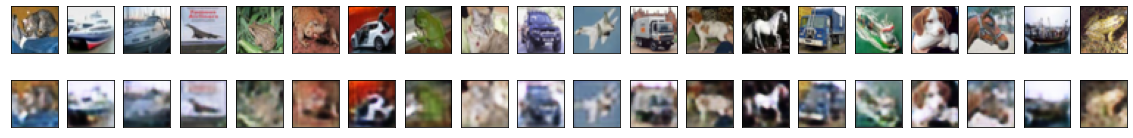

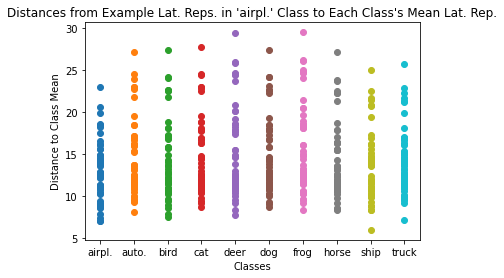

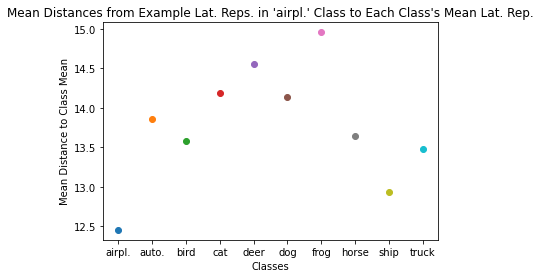

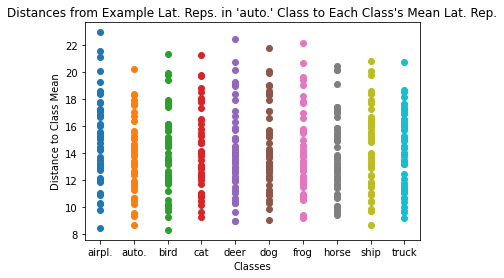

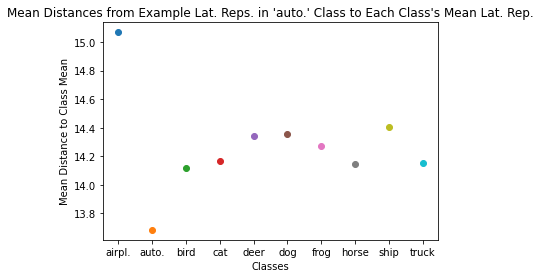

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Spencer Bowen
Convolutional Autoencoder for cifar10 dataset
"""

from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt


#---------------------------
# Construct and train model:
    
# Encoder
preprocessed_image = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(preprocessed_image)
x = BatchNormalization()(x)
x = Conv2D(4, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded_image = Conv2D(4, (3, 3), strides=(2, 2), activation='relu',\
                       padding='same')(x)
encoder = Model(inputs=preprocessed_image, outputs=encoded_image)
# We have compressed a 32*32*3=3072 dim. input to a 8*8*4=256 dim. representation 
# Decoder
encoded_image = Input(shape=(8, 8, 4))
x = UpSampling2D((2, 2))(encoded_image)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
decoded_image = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(inputs=encoded_image, outputs=decoded_image)
 
encoded_image = encoder(preprocessed_image)
decoded_image = decoder(encoded_image)
conv_auto = Model(preprocessed_image, decoded_image)
conv_auto.compile(optimizer='rmsprop', metrics=['accuracy'],\
                  loss='mean_squared_error')

print(encoder.summary())
print(decoder.summary())
print(conv_auto.summary())

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize dataset
train_images = train_images / 255.
test_images = test_images / 255.

class_dict = {0: 'airpl.', 1: 'auto.', 2: 'bird', 3: 'cat', 4: 'deer',
               5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

from keras.callbacks import TensorBoard
# To view plot of cost function on train and dev sets enter the following into
# a terminal and visit the generated web address: 
# tensorboard --logdir=/tmp/conv_auto

conv_auto.fit(train_images, train_images, epochs=5, batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_images),
                callbacks=[TensorBoard(log_dir='/tmp/conv_auto')])

decoded_test_images = conv_auto.predict(test_images)


#---------------------------------
# Visualize trained-model outputs:

k = 20
plt.figure(figsize=(20, 2.5))
for i in range(k):
    # input test images
    ax = plt.subplot(2, k, i + 1)
    plt.imshow(test_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed test images
    ax = plt.subplot(2, k, i + 1 + k)
    plt.imshow(decoded_test_images[i]) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# take mean of each class's latent representations, then compare distance 
# between individual class elements and their class's mean and other class's
# means
latentvec_dict = {}
meanvec_dict = {}
latentvecdist_dict = {}
meanlatvecdist_dict = {} 
for i in range(10):
    enc_pred = encoder.predict(test_images[np.where(test_labels[:, 0] == i)])
    h = np.shape(enc_pred)
    encodeddim = h[1]*h[2]*h[3]
    lvd = np.reshape(enc_pred, (h[0], encodeddim))
    latentvec_dict.update({i : lvd})
    tmp =  np.reshape(np.mean(latentvec_dict[i], axis = 0), (1, encodeddim))    
    meanvec_dict.update({i : tmp})
    
for i in range(10):    
    for j in range(10):
        dist = np.linalg.norm(latentvec_dict[i] - meanvec_dict[j], axis = 1)
        latentvecdist_dict.update({10*i+j : dist})  
        mdist = np.mean(latentvecdist_dict[10*i+j])
        meanlatvecdist_dict.update({10*i+j : mdist})
        
def plot_dist_to_mean_latent(class_key, num_ex_to_plot):
    h = np.shape(latentvec_dict[class_key])
    num = np.random.choice(h[0], num_ex_to_plot)
    b = list(range(num_ex_to_plot))
    for i in range(10):
        for j in range(num_ex_to_plot):
            b[j] = class_dict[i]
        plt.scatter(b, latentvecdist_dict[10*class_key + i][num])
    
    plt.title("Distances from Example Lat. Reps. in '"+ class_dict[class_key]\
                 + "' Class to Each Class's Mean Lat. Rep.")
    plt.xlabel('Classes')
    plt.ylabel('Distance to Class Mean')
    plt.show()
    
def plot_mean_dist_to_mean_latent(class_key):
    for i in range(10):
        b = class_dict[i]
        plt.scatter(b, meanlatvecdist_dict[10*class_key + i])
    
    plt.title("Mean Distances from Example Lat. Reps. in '"\
              + class_dict[class_key]+"' Class to Each Class's Mean Lat. Rep.")
    plt.xlabel('Classes')
    plt.ylabel('Mean Distance to Class Mean')
    plt.show()

plot_dist_to_mean_latent(0, 50)
plot_mean_dist_to_mean_latent(0)
plot_dist_to_mean_latent(1, 50)
plot_mean_dist_to_mean_latent(1)